# GP function testing

Motive:
- Check the implementation (`gaussian_algebra.py`) on some toy data.
- Check the influence of a radial basis function versus periodic kernel with period 2pi.

In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from python import gaussian_algebra, gaussian_plots
np.set_printoptions(precision=3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Test the conditioning

sd 2 : 0.4264014327112209


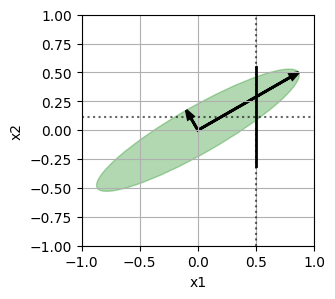

In [2]:
# 2D visualization
m, Q = gaussian_algebra.get_2D_cov_matrix(angle_deg=30, scale=(1, .2))

ax = gaussian_plots.init_cov_plot()
_, eigenvectors = gaussian_plots.plot_cov_ellipse(Q, m, ax=ax, alpha=0.3, color='green')
gaussian_plots.plot_2d_covariance_eigenvectors(Q, m, ax)

# Condition on some known x1 to get p(x2|x1)
x1 =0.5
m2, Q2 = gaussian_algebra.gaussian_condition(m, Q, x1=np.asarray((x1,)))  # m2, Q2
m2 = m2[0]
sd_2 = np.sqrt(Q2[0,0])

# Plot
ax.axvline(x1, color='k', linestyle=':', alpha=0.6)
ax.axhline(m2, color='k', linestyle=':', alpha=0.6)
ax.plot([x1, x1], [m2+sd_2, m2-sd_2], color='k', linewidth=2)
print('sd 2 :', sd_2)

### Check the functions for making a GP fit.

Define:
- a ground truth function.
- some measured points (data).
- points we're interested in.

Then condition on the points we're interested in given the data.

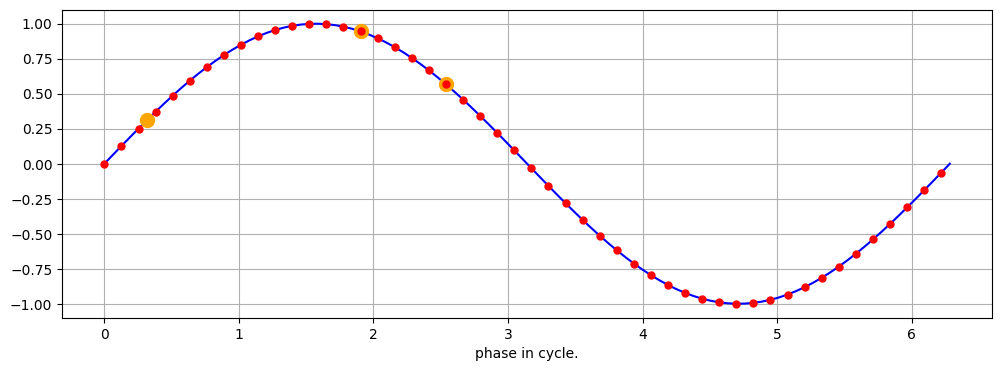

In [3]:
x_true = np.linspace(0, 2*np.pi, 100)

# Make up a ground-truth signal.
s_true = np.asarray([np.sin(xi) for xi in x_true])

# Sample some known points (measured data)
i_sampled = np.asarray([5, 30, 40])
x_sampled = np.asarray([x_true[i] for i in i_sampled])
s_sampled = np.asarray([s_true[i] for i in i_sampled])

# Points that we wish to evaluate
x_eval = x_true[::2]
s_eval = s_true[::2]
# x_eval = x_true[5::2]
# s_eval = s_true[5::2]

_, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(x_true, s_true, color='blue')
ax.plot(x_sampled, s_sampled, color='orange', linestyle='none', marker='o', markersize=10)
ax.plot(x_eval, s_eval, color='red', linestyle='none', marker='o', markersize=5, label='Points to evaluate')
ax.set_xlabel('phase in cycle.')
ax.grid()

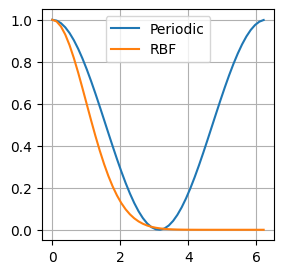

In [4]:
# Define some kernel
def K_rbf(x, l=1):
    """Radial basis function kernel"""
    delta_x = x[1]-x[0]
    r_sq = delta_x**2
    l_sq = l**2
    return np.exp(-r_sq/(2*l_sq))

def K_periodic(x, l=2.3):
    """Periodic on exactly 2pi"""
    delta_x = x[1]-x[0]
    num = -2*np.sin(delta_x/2)**2
    l_sq = l**2
    # return np.exp(num/(l_sq))
    return 1+ num/2

# Compare the two kernels
corr_periodic = np.asarray([K_periodic([0, xi]) for xi in x_eval])
corr_rbf = np.asarray([K_rbf([0, xi]) for xi in x_eval])
_, ax = plt.subplots(1,1, figsize=(3,3))
ax.grid()
ax.plot(x_eval, corr_periodic, label='Periodic')
ax.plot(x_eval, corr_rbf, label='RBF')
ax.legend()

Last minus first : -0.05515072320357779


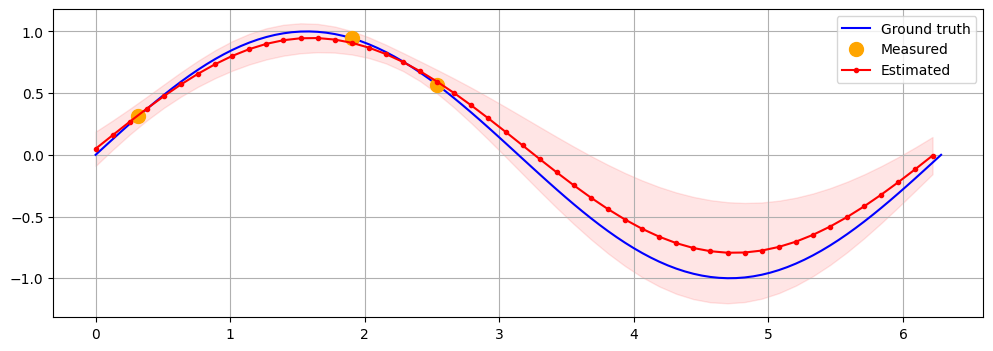

In [5]:

# Create covariance matrix - the lazy way.
sigma_y_sq = 0 
x_combined = np.concat( (x_sampled, x_eval))
n_combined = len(x_combined)

K_combined = sigma_y_sq*np.eye(n_combined)
for i in range(n_combined):
    for j in range(n_combined):
        x = np.asarray( [x_combined[i], x_combined[j] ])

        # Choose the kernel here.
        K_combined[i, j] = K_periodic(x)  

m_combined = np.zeros(n_combined)

# Condition the points to evaluate on the data.
s_eval_gp, Q_gp = gaussian_algebra.gaussian_condition(m_combined, K_combined, s_sampled, sigma=.1)
sd_eval = np.sqrt(np.diag(Q_gp))
print('Last minus first :', s_eval_gp[-1]-s_eval_gp[0])

# Plotting
_, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(x_true, s_true, color='blue', label='Ground truth')
ax.plot(x_sampled, s_sampled, color='orange', linestyle='none', marker='o', markersize=10, label='Measured')

ax.plot(x_eval, s_eval_gp, color='red', linestyle='-', marker='o', markersize=3, label='Estimated')
ax.fill_between(x_eval, s_eval_gp-sd_eval, s_eval_gp+sd_eval, color='red', alpha=0.1)

ax.grid()
ax.legend()

# Conclusion
Both kernels give plausible results. The periodicity assumption is pretty powerfull to extrapolation.

The tuning of the hyperparameters is quite critical.
